###  Let's calculate higher order gradients som hessian!
I added `keep_graph` and `zero_grad` flags to the gradient call. 
- The first one `keep_graph` is used to calculate gradients using `Value`. By doing that we record how the gradient is calculated from inputs.
- The second one is `zero_grad`. We set the gradient of variables to zero, however there might be other hidden variables that we are not setting to zero during second backprop, if enabled, we set the gradient of variables that are connected to the loss to zero during our topological sort. This is set to `True` by default.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

Let's take derivatives of $y = x^3 $.
- First derivative: $\frac{dy}{dx} = 3x^2 $
- Second derivative $\frac{dy}{dx^2} = 6x $
- Third derivative $\frac{dy}{dx^3} = 6 $
- Forth derivative $\frac{dy}{dx^4} = 0 $

In [12]:
x = Value(3)
# y = x*x*x
y = x**3
print('x:', x.data)
print('y:', y.data)
x.grad = 0 # We don't have to do it as long as x is connected to y. But lets do it anyway.
y.backward()
dy = x.grad
print('First derivative:', dy.data)
x.grad = 0
dy.backward()
d2y = x.grad
print('Second derivative:', d2y.data)
x.grad = 0
d2y.backward()
d3y = x.grad
print('Third derivative:', d3y.data)
# Here the x.grad is not going to be zerod automatically since it is disconnected from the results
# So, we _have to_ set it to zero.
d3y.backward()
d4y = x.grad
print('Fourth derivative:', d4y.data)


x: 3
y: 27
First derivative: 27
Second derivative: 18
Third derivative: 6
Fourth derivative: 0.0


# Classification Task from the Moon

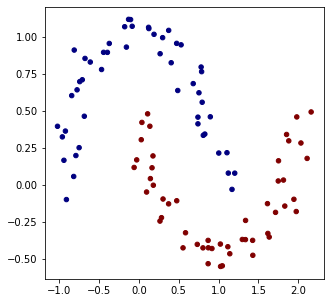

In [8]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [9]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [12]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


# Calculating Hessian row by row
Similar to what we did in 1d setting, we have to `keep_graph` to `True`. Then, we will calculate Hessian row by row. Specifically the i'th row of the hessian is the gradient of the i'th element of the gradient:
$$H[i,:] = \frac{d}{dx}(\frac{dy}{dx_i})$$

In [13]:
def calculate_hessian():
    # allocate hessian
    n = len(model.parameters())
    hessian = np.zeros(shape=(n, n))
    all_params = model.parameters()
    total_loss, _ = loss()
    # backward
    model.zero_grad()
    total_loss.backward(keep_graph=True)
    grads = [p.grad for p in all_params]
    for i, g_i in enumerate(grads):
        model.zero_grad()
        g_i.backward()
        for j, p2 in enumerate(all_params):
            hessian[i, j] = p2.grad
    return hessian

Text(0.5, 1.0, 'Eigen Spectrum of Hessian')

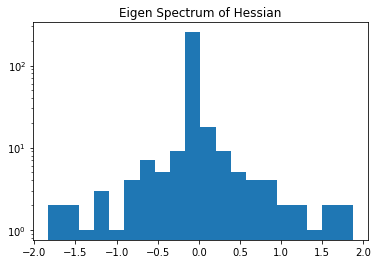

In [14]:
hessian = calculate_hessian()
eigvals, eigvecs = np.linalg.eigh(hessian)
plt.hist(eigvals, bins=20)
plt.yscale('log')
plt.title('Eigen Spectrum of Hessian')